# Preserving Human Large Scale Brain Connectivity Fingerprint Identifiability with Random Projections

This is a Jupyter notebook providing the source code which generated the figures in the aforementioned paper. This is provided for reproducability and transparency purposes.

In [55]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
sns.set_palette('deep')
sns_font_scale = 1.2

# Simulated Data

## Average approximated identifability
Here we create a random simulated data matrix drawn from various distributions and then approximate their identifiability. We take 1000 simulations and compute the average identifiability as well as a histogram depicting the approximated values.

In [56]:
p = 0.05 # For the histogram part
p_array = np.array([0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.33, 0.5]) # For boxplot/rmse part
data_dims = (10000,100) # 10000 "connections" and 100 "patients"
simulations = 1000
noise_level = 0.01
seed = 2023 # Set once for convenience; needs to be set each new cell. Default: 2023

In [57]:

np.random.seed(seed)

X1 = -0.5+np.random.rand(data_dims[0],data_dims[1])
X2 = np.random.normal(size=data_dims)
X3 = np.empty(data_dims)
X3[:,0] = np.random.normal(size=data_dims[0])
for j in np.arange(1,data_dims[1]):
    X3[:,j] = X3[:,j-1]+np.random.normal(scale=0.1, size=X3[:,j-1].shape)
X4 = np.hstack((X1, X1+np.random.normal(size=X1.shape, scale=noise_level)))
X5 = np.hstack((X2, X2+np.random.normal(size=X2.shape, scale=noise_level)))
X6 = np.hstack((X3, X3+np.random.normal(size=X3.shape, scale=noise_level)))

# Double stacking so that compute_identifiability uses X1,X2,X3 for both parts.
X1 = np.hstack((X1,X1))
X2 = np.hstack((X2,X2))
X3 = np.hstack((X3,X3))

# Containers for result data, no need to touch
approx_levels = np.empty((7,len(p_array), simulations))
approx_data = np.empty((7,simulations))
rmse_array = np.empty((7,len(p_array)))


In [58]:
def compute_identifiability(X):
    """
    Compute identifiability of data matrix X. Each column is a
    patient, each row is a brain region pair.
    """
    n = int(X.shape[1]/2)
    corr_X = np.corrcoef(X, rowvar=False)[:n,n:]
    corr_diag_mean = np.trace(corr_X)/n
    corr_off_diag_mean = (np.sum(corr_X)-np.trace(corr_X))/(n**2-n)
    return corr_diag_mean - corr_off_diag_mean

def approximate_identifiability(X, p=0.05):
    """
    Approximate identifiability with a random subsampling given a matrix X
    and a probability of edge retention p.
    """
    index = np.empty(0)
    for i in range(X.shape[0]):
        if np.random.rand(1) < p:
            index = np.append(index, i)
    index = index.astype(int)
    proj_X = X[index,:]
    return compute_identifiability(proj_X)

## Histograms

In [59]:
np.random.seed(seed)

for sim in tqdm(range(simulations), desc='Uniform'):
    approx_data[0,sim] = approximate_identifiability(X1,p)

for sim in tqdm(range(simulations), desc='Gaussian'):
    approx_data[1,sim] = approximate_identifiability(X2,p)

for sim in tqdm(range(simulations), desc='Correlated'):
    approx_data[2,sim] = approximate_identifiability(X3,p)

for sim in tqdm(range(simulations), desc='Uniform (Noise)'):
    approx_data[3,sim] = approximate_identifiability(X4,p)

for sim in tqdm(range(simulations), desc='Gaussian (Noise)'):
    approx_data[4,sim] = approximate_identifiability(X5,p)

for sim in tqdm(range(simulations), desc='Correlated (Noise)'):
    approx_data[5,sim] = approximate_identifiability(X6,p)

Correlated (Noise): 100%|██████████| 1000/1000 [00:34<00:00, 28.76it/s]


## Boxplot

In [60]:
np.random.seed(seed)

for p_index in tqdm(range(p_array.shape[0]), desc='Uniform'):
    for trial in range(simulations):
        approx_levels[0,p_index,trial] = approximate_identifiability(X1, p_array[p_index])

for p_index in tqdm(range(p_array.shape[0]), desc='Gaussian'):
    for trial in range(simulations):
        approx_levels[1,p_index,trial] = approximate_identifiability(X2, p_array[p_index])

for p_index in tqdm(range(p_array.shape[0]), desc='Correlated'):
    for trial in range(simulations):
        approx_levels[2,p_index,trial] = approximate_identifiability(X3, p_array[p_index])

for p_index in tqdm(range(p_array.shape[0]), desc='Uniform (Noise)'):
    for trial in range(simulations):
        approx_levels[3,p_index,trial] = approximate_identifiability(X4, p_array[p_index])

for p_index in tqdm(range(p_array.shape[0]), desc='Gaussian (Noise)'):
    for trial in range(simulations):
        approx_levels[4,p_index,trial] = approximate_identifiability(X5, p_array[p_index])

for p_index in tqdm(range(p_array.shape[0]), desc='Correlated (Noise)'):
    for trial in range(simulations):
        approx_levels[5,p_index,trial] = approximate_identifiability(X6, p_array[p_index])

Correlated (Noise): 100%|██████████| 9/9 [06:25<00:00, 42.88s/it]


## RMSE Computations

In [61]:
idx_array = np.empty(6)
X_dict = {0:X1, 1:X2, 2:X3, 3:X4, 4:X5, 5:X6}
for i in range(6):
    idx_array[i] = compute_identifiability(X_dict[i])

for i in range(6):
    for p_index in range(len(p_array)):
        rmse_array[i,p_index] = np.sqrt(np.sum((idx_array[i]-approx_levels[i,p_index,:])**2)/len(approx_levels[i,p_index,:]))

## Simulation Plots

* Row 1: Noiselss
* Row 2: Noise
* Col 1: Uniform
* Col 2: Gaussian
* Col 3: Correlated

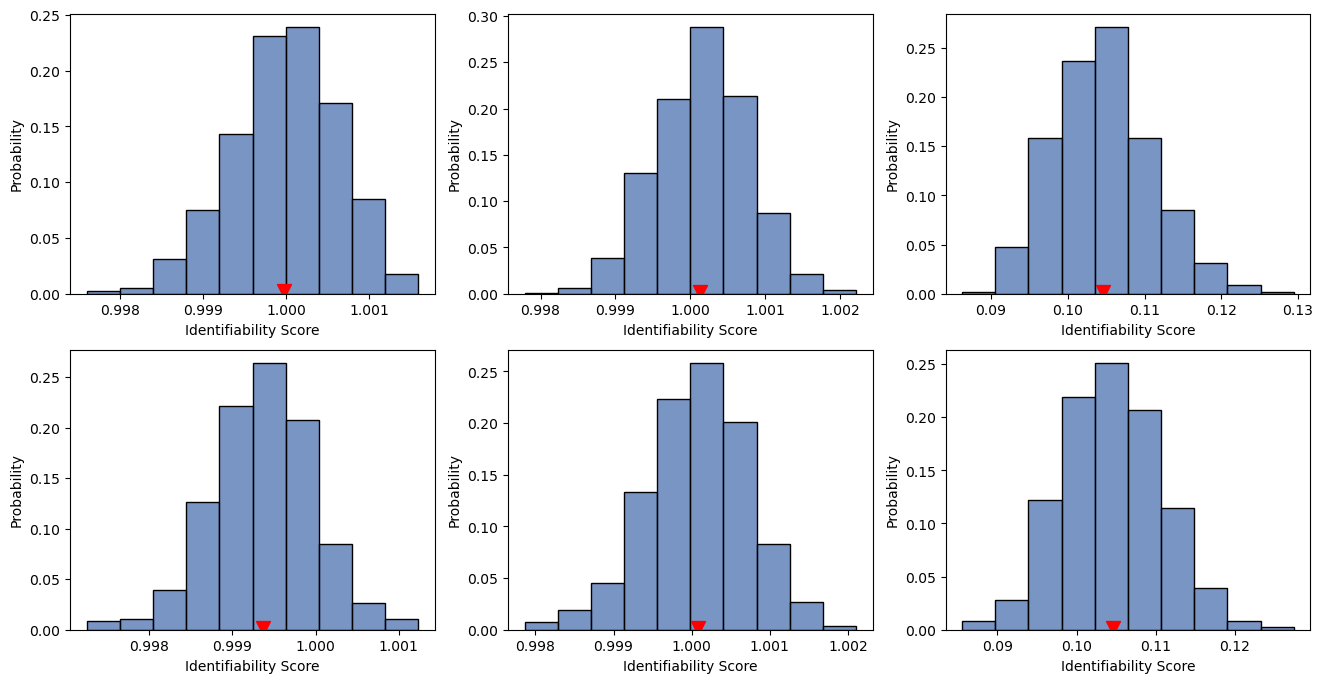

In [62]:
fig = plt.figure(1, figsize=(16,8))

for i in range(6):
    ax = fig.add_subplot(2,3,i+1)
    sns.histplot(data=approx_data[i,:].T, stat='probability', bins=10, ax=ax)
    ax.scatter(idx_array[i], [0.002], c='r', marker='v', s=100)
    ax.set_xlabel('Identifiability Score')

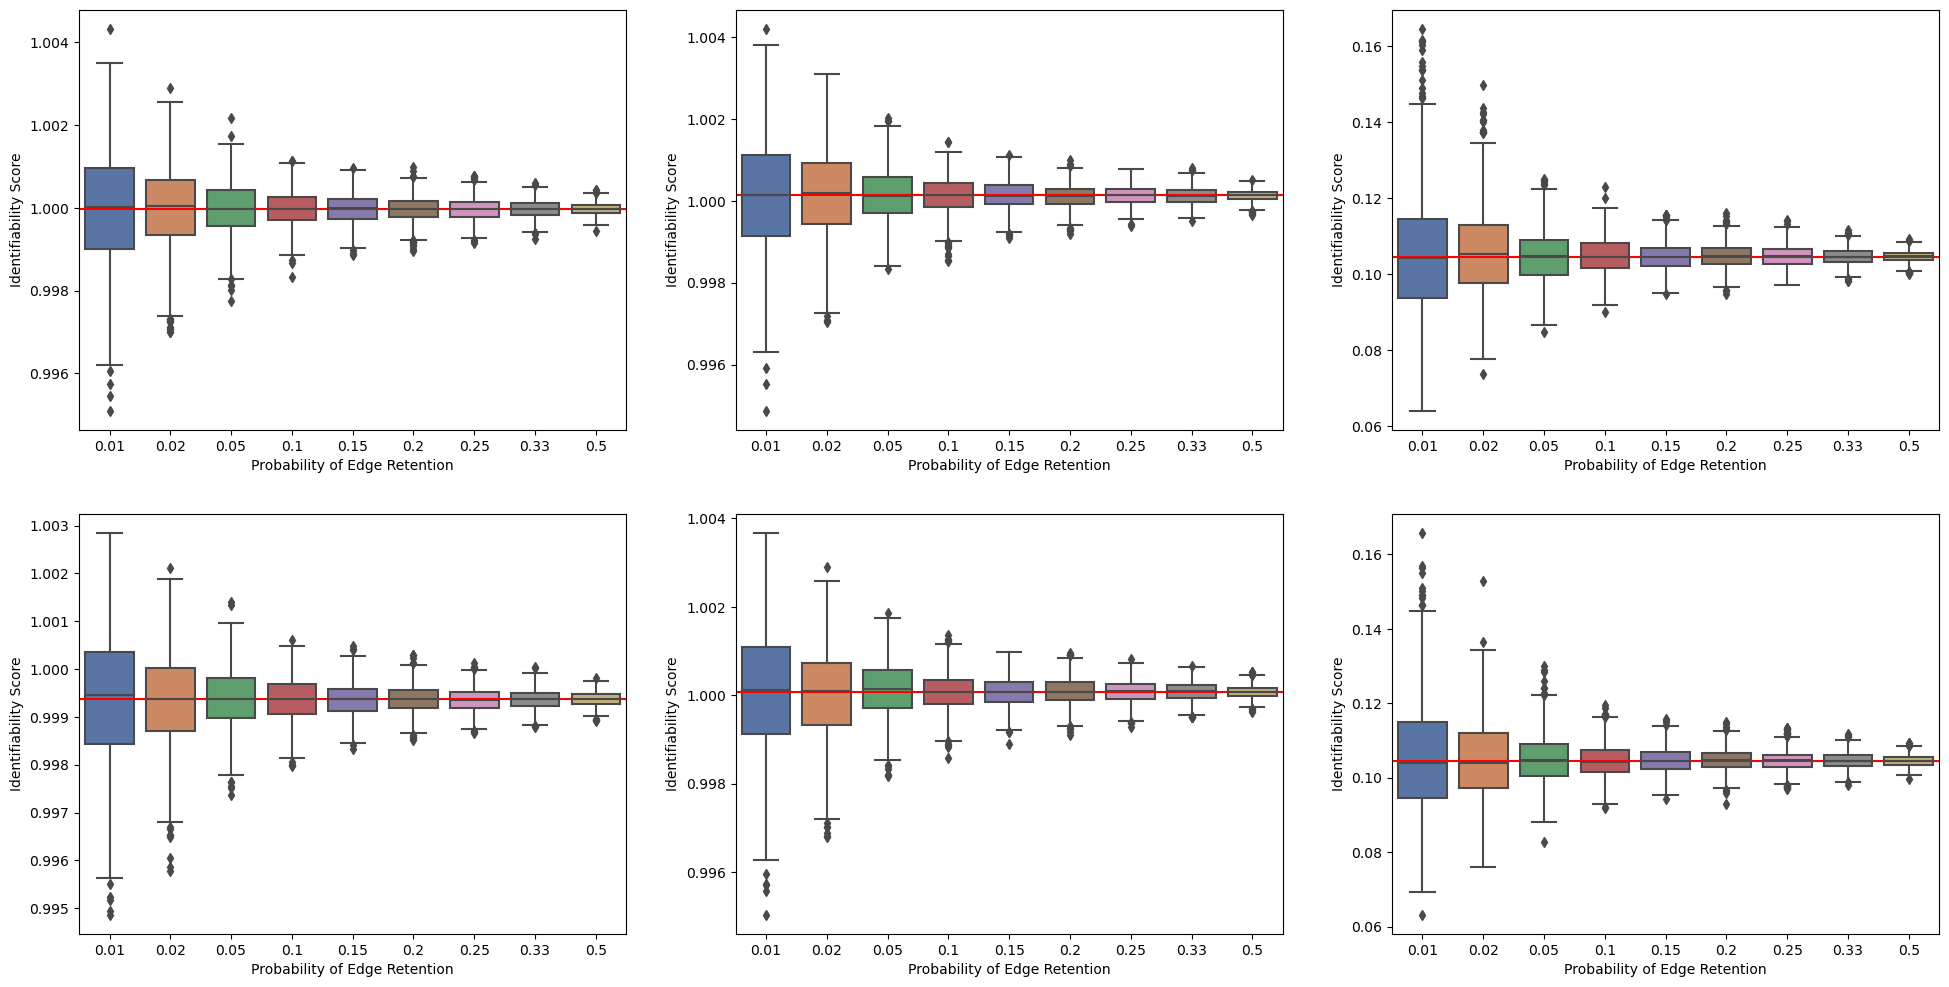

In [63]:
fig = plt.figure(2, figsize=(24,12))
redline = np.arange(-0.5, p_array.shape[0]-0.4, 0.1)

for i in range(6):
    approx_df = pd.DataFrame(data=approx_levels[i,:,:].T, columns = p_array)
    ax = fig.add_subplot(2,3,i+1)
    sns.boxplot(data=approx_df)
    ax.plot(redline, np.repeat(idx_array[i], redline.shape[0]), c='r')
    ax.set_xlabel('Probability of Edge Retention')
    ax.set_ylabel('Identifiability Score')

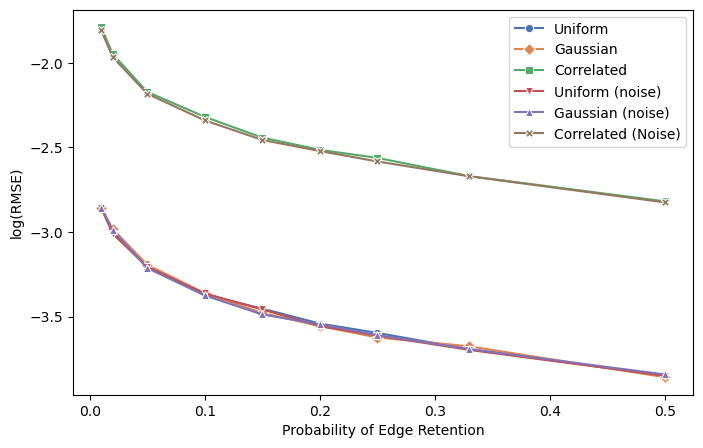

In [64]:
fig = plt.figure(3, figsize = (8,5))
ax = fig.add_subplot(111)
labels = ['Uniform','Gaussian','Correlated','Uniform (noise)','Gaussian (noise)','Correlated (Noise)']
markers = ['o', 'D', 's', 'v', '^', 'X']
for i in range(6):
    sns.lineplot(x=p_array, y=np.log10(rmse_array[i,:]), label=labels[i], ax=ax, marker=markers[i])
ax.set_xlabel('Probability of Edge Retention')
ax.set_ylabel('log(RMSE)')
ax.legend()

# Emperical Results

Vectorize from data by only taking entries in upper triangle (lower triangle redundant).

In [65]:
test_data = np.load('100_unrelated_sub_FC_374_rfMRI_Rest1_LR.npy')
retest_data = np.load('100_unrelated_sub_FC_374_rfMRI_Rest1_RL.npy')
m = test_data.shape[0]
n = test_data.shape[1]
N = int(n*(n+1)/2)
X = np.zeros((N,2*m))
for i in range(m):
    Ur, Uc = np.where(np.triu(test_data[i,:,:] != 0))
    X[:,i] = test_data[i, Ur, Uc].flatten()
    Ur, Uc = np.where(np.triu(retest_data[i,:,:] != 0))
    X[:,i+m] = retest_data[i, Ur, Uc].flatten()


In [66]:
np.random.seed(seed)

for sim in tqdm(range(simulations), desc=f'fMRI p={p}'):
    approx_data[6,sim] = approximate_identifiability(X,p)

for p_index in tqdm(range(p_array.shape[0]), desc='fMRI p-levels'):
    for trial in range(simulations):
        approx_levels[6,p_index,trial] = approximate_identifiability(X, p_array[p_index])

for p_index in range(len(p_array)):
        rmse_array[6,p_index] = np.sqrt(np.sum((compute_identifiability(X)-approx_levels[6,p_index,:])**2)/len(approx_levels[6,p_index,:]))

fMRI p-levels: 100%|██████████| 9/9 [47:39<00:00, 317.68s/it]


# Combined Results (Paper Figures)

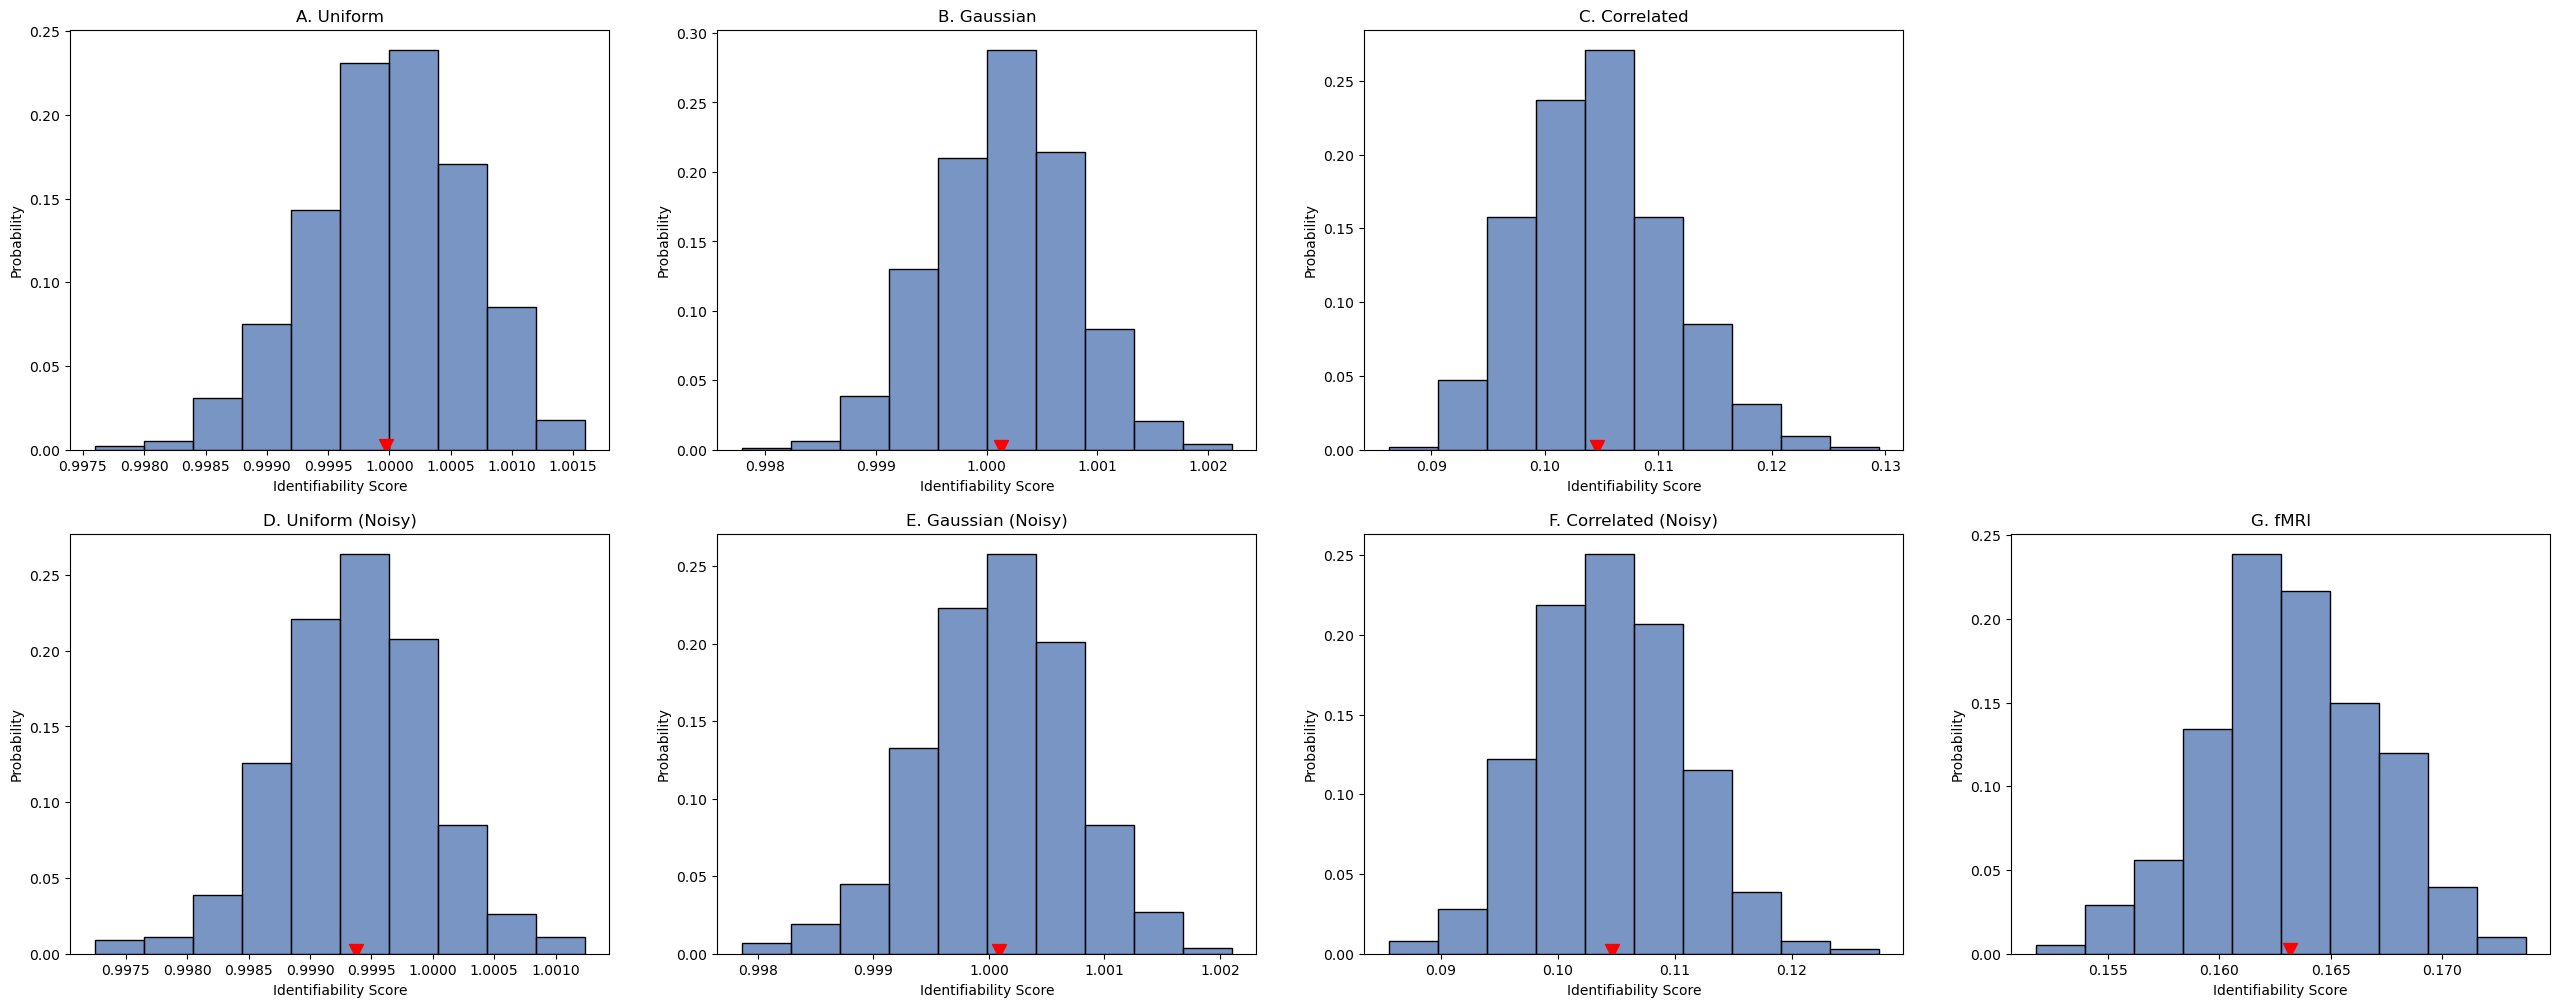

In [67]:
fig = plt.figure(1, figsize=(32,12))
subplot_order = [1,2,3,5,6,7,8] # Puts fMRI on 1st row, 4th col
subplot_labels = ['A. Uniform', 'B. Gaussian', 'C. Correlated', 'D. Uniform (Noisy)', 'E. Gaussian (Noisy)', 'F. Correlated (Noisy)', 'G. fMRI']
idx_array = np.append(idx_array, compute_identifiability(X))

for i in range(7):
    ax = fig.add_subplot(2,4,subplot_order[i])
    sns.histplot(data=approx_data[i,:].T, stat='probability', bins=10, ax=ax)
    ax.scatter(idx_array[i], [0.002], c='r', marker='v', s=100)
    ax.set_xlabel('Identifiability Score')
    ax.set_title(subplot_labels[i])

fig.savefig('approx_histograms.pdf', dpi=300, bbox_inches='tight', facecolor='w')

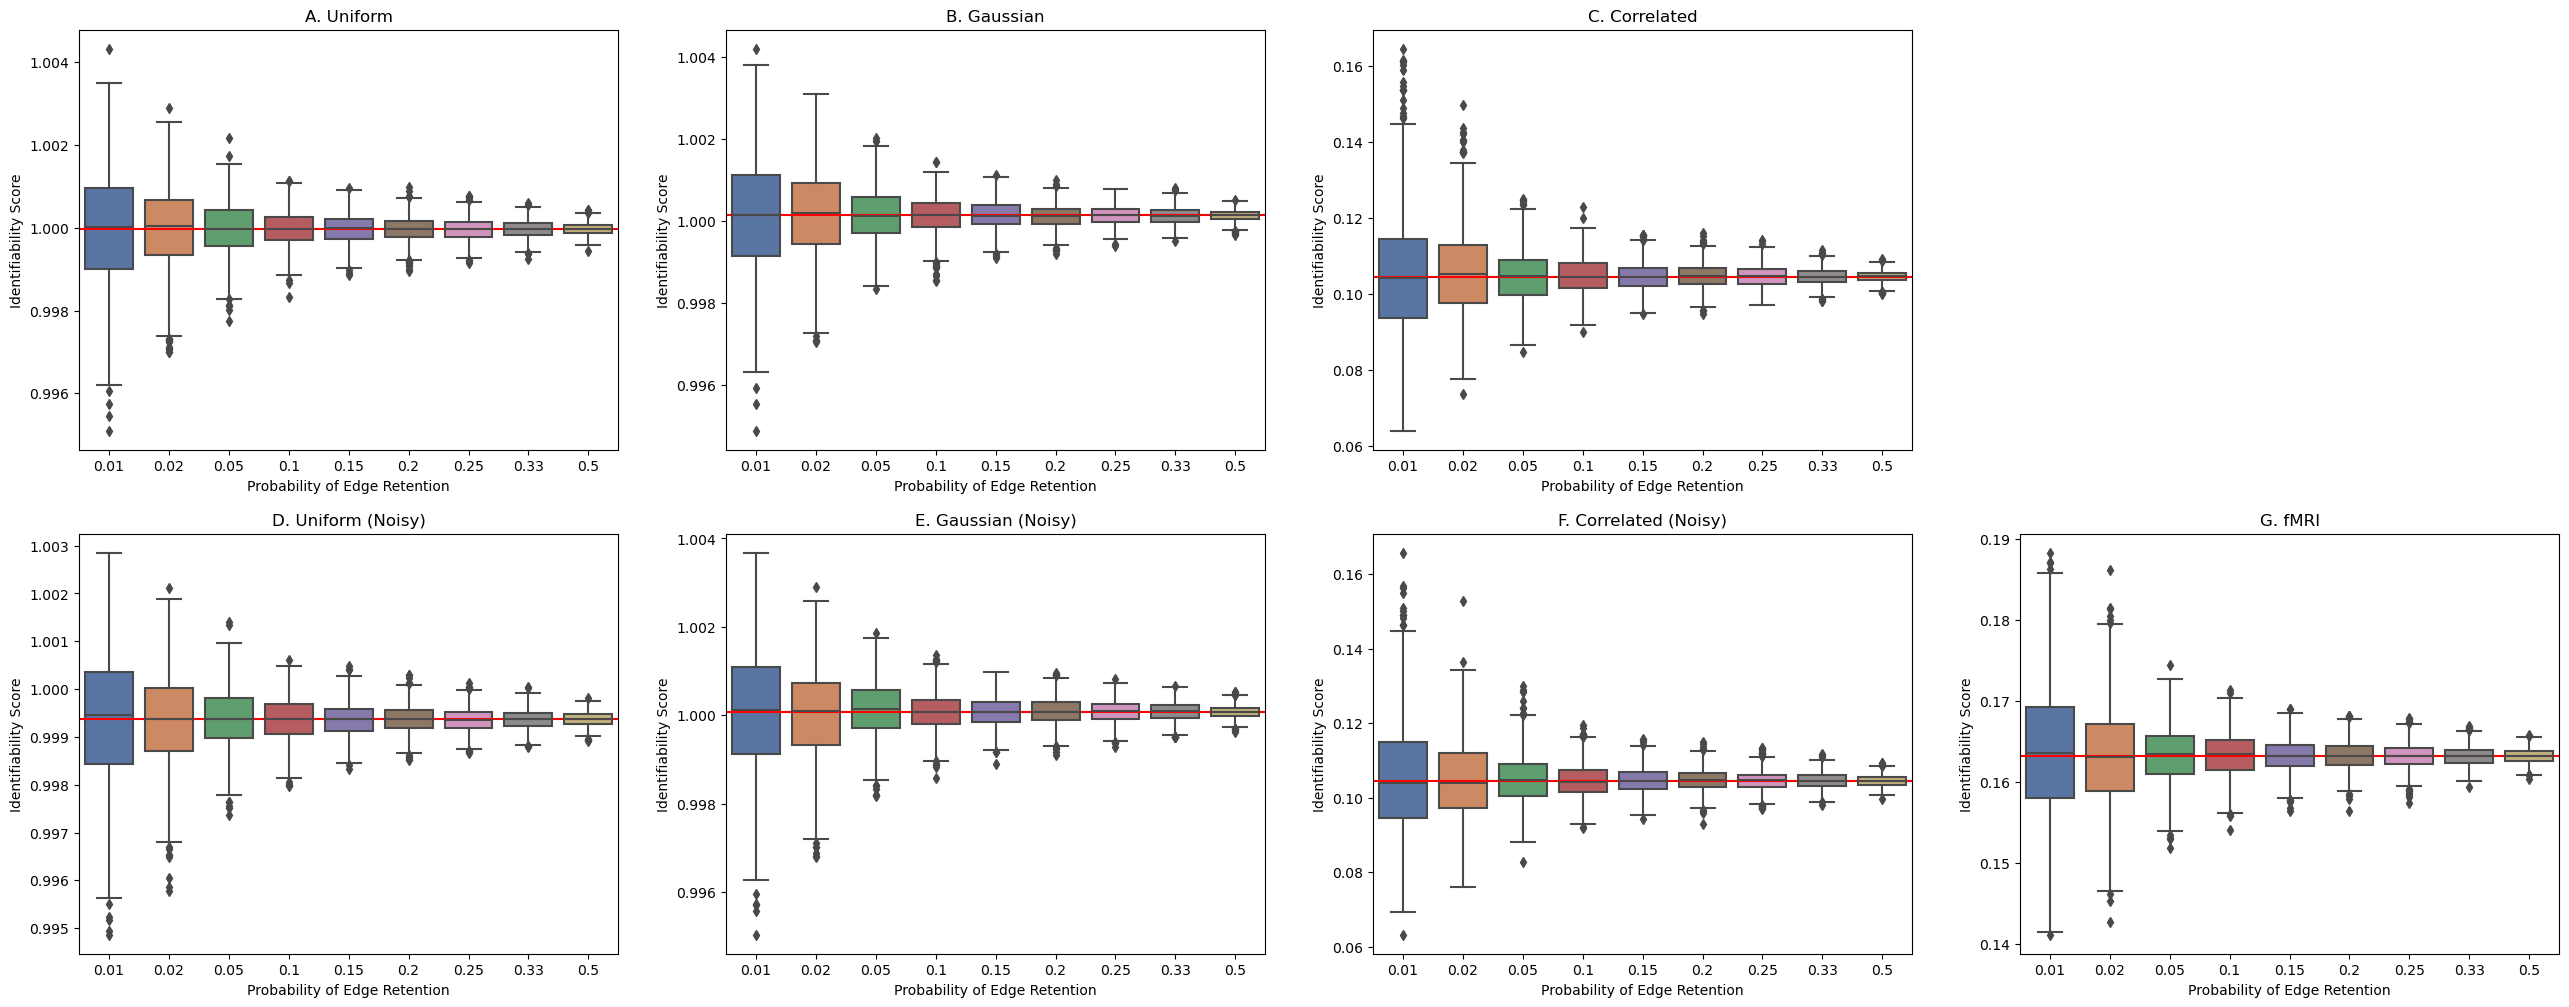

In [68]:
fig = plt.figure(2, figsize=(32,12))
subplot_order = [1,2,3,5,6,7,8] # Puts emperical on 1st row, 4th col
subplot_labels = ['A. Uniform', 'B. Gaussian', 'C. Correlated', 'D. Uniform (Noisy)', 'E. Gaussian (Noisy)', 'F. Correlated (Noisy)', 'G. fMRI']
redline = np.arange(-0.5, p_array.shape[0]-0.4, 0.1)

for i in range(7):
    approx_df = pd.DataFrame(data=approx_levels[i,:,:].T, columns = p_array)
    ax = fig.add_subplot(2,4,subplot_order[i])
    sns.boxplot(data=approx_df)
    ax.plot(redline, np.repeat(idx_array[i], redline.shape[0]), c='r')
    ax.set_xlabel('Probability of Edge Retention')
    ax.set_ylabel('Identifiability Score')
    ax.set_title(subplot_labels[i])

fig.savefig('approx_boxplot.pdf', dpi=300, bbox_inches='tight', facecolor='w')

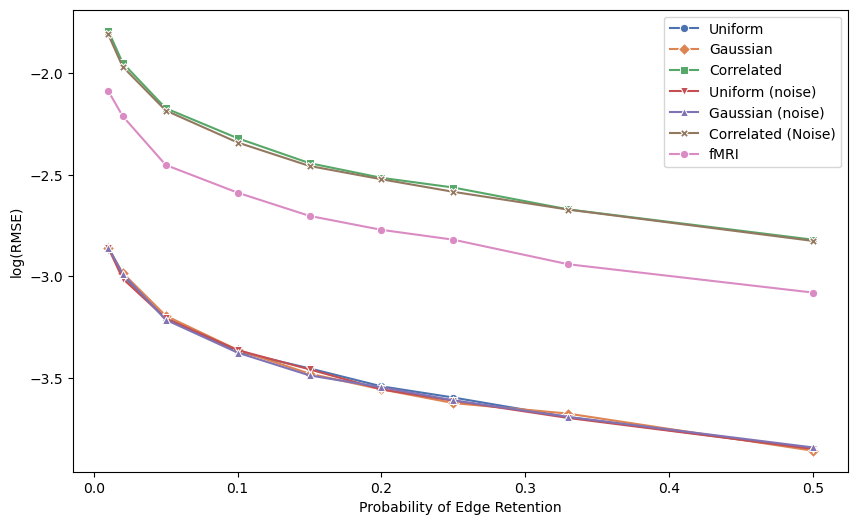

In [69]:
fig = plt.figure(3, figsize=(10,6))
ax = fig.add_subplot(111)
labels = ['Uniform','Gaussian','Correlated','Uniform (noise)','Gaussian (noise)','Correlated (Noise)', 'fMRI']
markers = ['o', 'D', 's', 'v', '^', 'X', 'o']
for i in range(7):
    sns.lineplot(x=p_array, y=np.log10(rmse_array[i,:]), label=labels[i], ax=ax, marker=markers[i])
ax.set_xlabel('Probability of Edge Retention')
ax.set_ylabel('log(RMSE)')
ax.legend()

fig.savefig('approx_rmse.pdf', bbox_inches='tight', dpi=300, facecolor='w')

In [71]:
np.savetxt('approx_data.csv', approx_data)
#np.savetxt('approx_levels.csv', approx_levels)
np.savetxt('rmse_data.csv', rmse_array)